<a href="https://colab.research.google.com/github/jackie-Gung/Colab_ESAA/blob/main/2022_05_27_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# 필요한 라이브러리 호출하기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

## **06. 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷**
---
### **| 개요**
- 좋은 머신러닝 회귀 모델의 특징?
- 앞서 다항 회귀에서 degree가 1인 경우는 지나치게 예측 곡선을 단순화해 데이터에 적합하지 않는 과소적합 모델이 만들어짐
- 반대로 degree가 15인 경우, 지나치게 모든 데이터에 적합한 회귀식을 만들기 위해 다항식이 복잡해지고 회귀 계수가 매우 크게 설정되면서 평가 데이터 세트에 대해 형편없는 예측 성능을 보임
- 따라서 회귀 모델은 적절히 데이터에 적합하면서도 회귀 계수가 기하급수적으로 커지는 것을 제어해야함
- 이전까지 선형 모델의 비용 함수는 RSS를 최소화하는, 즉 실제 값과 예측 값의 차이를 최소화하는 것만 고려함
- 그러다 보니 학습 데이터에 지나치게 맞추게 되고, 회귀 계수가 쉽게 커짐
- 이를 반영해 비용 함수는 학습 데이터의 잔차 오류 값을 최소로 하는 RSS 최소화 방법과 과적합을 방지하기 위해 회귀 계수 값이 커지지 않도록 하는 방법이 서로 균형을 이루어야 함
- 회귀 계수의 크기를 제어해 과적합을 개선하려면 비용 함수의 목표가 RSS(W)+alpha*||W||를 최소화하는 것으로 변경될 수 있음
$$ 비용 함수 목표 = MIN(RSS(W)+alpha*||W||^2_2) $$

- 여기서 alpha는 학습 데이터 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터임
- 비용 함수 목표가 저 식을 최소화하는 W 벡터를 찾는 것일 때 alpha가 어떤 역할을 하는지 살펴볼 예정

- alpha가 0(매우 작은 값)이라면 비용 함수 식은 기존과 동일한 MIN(RSS(W)+0)이 될 것임
- 반면에 alpha가 무한대(매우 큰 값)이라면 비용 함수 식은 RSS(W)에 비해 $alpha*||W||^2_2$값이 너무 커지게 되므로 W 값을 0으로 만들어야 비용이 최소화되는 비용 함수 목표를 달성할 수 있음
- 즉 alpha 값을 크게 하면 비용 함수는 최귀 계수 W 값을 작게하여 과적합을 개선할 수 있으며, alpha 값을 작게 하면 회귀 계수 W 값이 커져도 어느 정도 상쇄가 가능하므로 학습 데이터 적합을 더 개선 가능함
- 정리
      1. alpha=0: W가 커도 $alpha*||W||^2_2$가 0이 되어 비용 함수 = Min(RSS(W))
      2. alpha=infinite: $alpha*||W||^2_2$가 무한대가 되므로 비용함수는 W를 0에 가깝게 최소화해야함

- 즉, alpha를 0에서부터 지속적으로 값을 증가시키면 회귀 계수 값을 감소시킬 수 있음
- 규제(Regulation): 비용 함수에 alpha 값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식
  - 규제 방식
      1. L2: $alpha*||W||^2_2$와 같이 W 제곱에 대해 패널티를 부여하는 방식
        - 릿지(Ridge)회귀
      2. L1: $alpha*||W||_1$와 같이 W 절대값에 대해 패널티를 부여하는 방식
        - 라쏘(Lasso)회귀
        - 영향력이 크지 않은 회귀 계수 -> 0

### **| 릿지 회귀**
- 사이킷런은 Ridge 클래스를 통해 릿지 회귀를 구현함
- 주요 생성 파라미터: alpha (L2 규제 계수)
- 앞 예제의 보스턴 주택 가격을 Ridge 클래스를 이용해 다시 예측하고, 예측 성능을 cross_val_score()로 평가해보기

In [26]:
# 보스턴 데이터 세트 로드하기
boston = load_boston()

# boston 데이터 세트 dataframe으로 변환하기
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston 데이터 세트의 target 배열은 주택 가격으로, 이를 price 칼럼으로 데이터프레임에 추가하기
bostonDF['PRICE']=boston.target

# target/feature 분리하기
y_target = bostonDF['PRICE']
X_data = bostonDF.drop('PRICE', axis=1, inplace = False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [27]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행하기
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring='neg_mean_squared_error',cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds 개별 Negative MSE scores: ', np.round(neg_mse_scores,3))
print('5 folds 개별 RMSE scores: ', np.round(rmse_scores,3))
print('5 folds 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
5 folds 평균 RMSE: 5.518


- 결과
      1. 5개 폴드의 평균 RMSE 값은 5.518
      2. 앞 예제의 규제가 없는 LinearRegression의 5.836보다 더 뛰어난 성능을 보임

- 릿지 alpha 값을 0,0.1,1,10,100으로 변화시키면서 RMSE와 회귀 계수 값의 변화를 살펴보기
- 릿지 회귀는 alpha값이 커질수록 회귀 계수를 작게 만듦

In [28]:
# 릿지에 사용할 alpha 파라미터값 정의하기
alphas = [0,0.1,1,10,100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse 구하기
for alpha in alphas:
  ridge = Ridge(alpha = alpha)

  # cross_val_scsore를 이용해 5개 폴드의 평균 RMSE 계산하기
  neg_mse_scores = cross_val_score(ridge,X_data,y_target,scoring='neg_mean_squared_error',cv=5)
  avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
  print('alpha {0}일 때 5개 폴드의 평균 RMSE: {1:.3f}'.format(alpha, avg_rmse))

alpha 0일 때 5개 폴드의 평균 RMSE: 5.829
alpha 0.1일 때 5개 폴드의 평균 RMSE: 5.788
alpha 1일 때 5개 폴드의 평균 RMSE: 5.653
alpha 10일 때 5개 폴드의 평균 RMSE: 5.518
alpha 100일 때 5개 폴드의 평균 RMSE: 5.330


- 결과
      1. alpha=100일 때 평균 RMSE가 5.330으로 가장 좋음

- alpha 값의 변화에 따른 피처의 회귀 계수 값을 가로 막대 그래프로 시각화하기
- 회귀 계수를 Ridge 객체의 coef_속성에 추출한 뒤에 Series 객체로 만들어서 seaborn 가로 막대 차트로 표시하고, 데이터프레임에 alpha 값별 회귀 계수로 저장하기

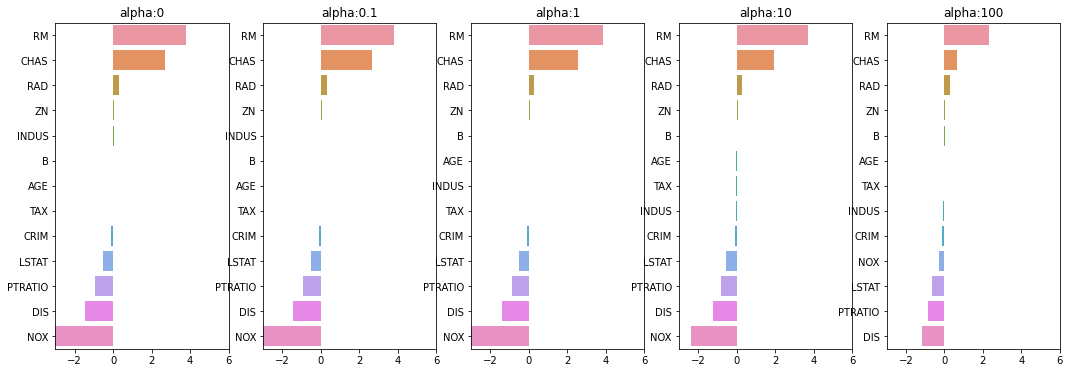

In [29]:
# 각 alpha에 따른 회귀 계수를 시각화하기 위해 5개 열로 된 맷플롯립 축 생성하기
fig, axs = plt.subplots(figsize=(18,6), nrows=1, ncols=5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 dataframe 생성하기
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장, pos는 axis 위치 지정하기
for pos, alpha in enumerate(alphas):
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_data,y_target)

  # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가하기
  coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
  colname = 'alpha:'+str(alpha)
  coeff_df[colname] = coeff

  # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화하기(계수값이 높은 순으로 정렬)
  coeff = coeff.sort_values(ascending=False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3,6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

# for문 밖에서 맷플롯립의 show 호출 및 alpha 값에 따른 피처별 회귀 계수를 DataFrame으로 표시하기
plt.show()

- 결과
      1. alpha 값이 커짐에 따라 회귀 계수가 작아짐
      2. 특히 NOX 피처는 alpha 값이 증가할수록 크게 감소하는 것을 볼 수 있음

In [30]:
# DataFrame에 저장된 alpha 값의 변화에 따른 릿지 회귀 계수 값을 구해보기

ridge_alphas = [0,0.1,1,10,100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


### **| 라쏘 회귀**
- W 절대값에 패널티를 부여하는 L1 규제를 선형 회귀에 적용하는 회귀
- 비용 함수의 목표: $ RSS(W) + alpha*||W||_1 $ 식을 최소화하는 W 찾기
- L2 규제가 회귀 계수 크기를 감소시키는 데 반해, L1 규제는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거함
- L1 규제는 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가지고 있음

- 사이킷런은 Lasso 클래스를 통해 라쏘 회귀를 구현함
- 주요 생성 파라미터: alpha
- alpha 값을 변화하면서 RMSE와 각 피처별 회귀 계수를 출력해보기
- get_linear_reg_eval()
  - 회귀 모델 이름
  - alpha 리스트
  - 피처/타깃 데이터 세트

In [31]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE 출력하고 회귀 계수값들을 DataFrame 반환

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True) :
  coeff_df = pd.DataFrame()
  if verbose : print('####### ', model_name, '#######')
  for param in params:
    if model_name == 'Ridge': model = Ridge(alpha=param)
    elif model_name == 'Lasso' : model = Lasso(alpha=param)
    elif model_name == 'ElasticNet' : model = ElasticNet(alpha=param,l1_ratio=0.7)
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n,
                                     scoring='neg_mean_squared_error', cv=5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5개 폴드 평균 RMSE: {1:.3f}'.format(param,avg_rmse))

    # cross_val_score: evaluation metric만 반환하므로 모델을 다시 학습해서 회귀 계수 추출하기
    model.fit(X_data, y_target)

    # alpha에 따른 피처별 회귀 계수를 Series 변환하고 이를 DataFrame 칼럼으로 추가하기
    coeff = pd.Series(data=model.coef_, index=X_data.columns)
    colname='alpha:'+str(param)
    coeff_df[colname] = coeff
  return coeff_df


In [32]:
lasso_alphas = [0.07,0.1,0.5,1,3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params = lasso_alphas,
                                     X_data_n=X_data,y_target_n=y_target)

#######  Lasso #######
alpha 0.07일 때 5개 폴드 평균 RMSE: 5.612
alpha 0.1일 때 5개 폴드 평균 RMSE: 5.615
alpha 0.5일 때 5개 폴드 평균 RMSE: 5.669
alpha 1일 때 5개 폴드 평균 RMSE: 5.776
alpha 3일 때 5개 폴드 평균 RMSE: 6.189


- 결과
      1. alpha=0.07일 때 가장 값이 좋음
      2. 앞서 릿지 평균인 5.330보다는 약간 떨어지는 수치지만, LinearRegression 평균인 5.836보다는 향상됨

In [33]:
# 반환된 coeff_lasso_df를 첫번째 칼럼순으로 내림차순 정렬해 회귀 계수 데이터프레임 출력하기
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


- 결과
      1. alpha값이 증가함에 따라 일부 피처의 회귀 계수가 0으로 바뀐 것을 알 수 있음
      2. NOX 피처는 alpha=0.07일때부터 회귀 계수가 0이며, CHAS는 0.5부터, INDUS는 1부터, RM과 CRIM, 그리고 DIS는 3일 때 0이 됨
      3. 회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있음

### **| 엘라스틱넷 회귀**
- L2와 L1 규제를 결합한 회귀
- 비용 함수의 목표: RSS(W)+alpha2*$||W||^2_2$ + alpha1*$||W||_1$ 식을 최소화하는 W 찾는 것
- 라쏘 회귀가 서로 상관관계가 높은 피처들의 경우 이들 중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드려는 성향이 강함
- 특히 이러한 성향으로 인해 alpha 값에 따라 회귀 계수 값이 급격히 변동할 수도 있는데, 엘라스틱넷 회귀는 이를 완화하기 위해 L2 규제를 라쏘 회귀에 추가한 것임
- 반대로 엘라스틱넷 회귀의 단점은 L1,L2 규제가 결합된 규제로 인해 수행시간이 오래 걸린다는 점

- 사이킷런은 ElasticNet 클래스를 통해서 엘라스틱넷 회귀를 구현함
- 주요 생성 파라미터: alpha, l1_ratio
  - ridge, lasso의 alpha와는 다름
  - a*L1 + b*L2이므로 엘라스틱넷 alpha = a+b
  - l1_ratio = a / (a+b)

In [34]:
# 엘라스틱넷에 사용될 alpha 파리미터의 값을 정의하고 get_linear_reg_eval() 함수 호출하기
# l1_ratio = 0.7

elastic_alphas = [0.07,0.1,0.5,1,3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params = elastic_alphas,
                                       X_data_n=X_data, y_target_n=y_target)

#######  ElasticNet #######
alpha 0.07일 때 5개 폴드 평균 RMSE: 5.542
alpha 0.1일 때 5개 폴드 평균 RMSE: 5.526
alpha 0.5일 때 5개 폴드 평균 RMSE: 5.467
alpha 1일 때 5개 폴드 평균 RMSE: 5.597
alpha 3일 때 5개 폴드 평균 RMSE: 6.068


In [35]:
# 반환된 coeff_elastic_df를 첫 번재 칼럼순으로 내림차순 정렬해 회귀 계수 dataframe 출력하기
sort_column = "alpha:"+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


- 결과
      1. alpha=0.5일 때 평균 RMSE가 5.547로 가장 좋은 예측 성능을 보임
      2. alpha값에 따른 피처들의 회귀 계수들 값이 라쏘보다는 상대적으로 0이 되는 값이 적음을 알 수 있음
      

### **| 선형 회귀 모델을 위한 데이터 변환**
- 선형 회귀 모델과 같은 선형 모델은 일반적으로 피처와 타깃값 간에 선형 관계가 있다고 가정하고, 이러한 최적의 선형 함수를 찾아내 결과값을 예측함
- 또한 선형 회귀 모델은 피처값과 타깃값의 분포가 정규 분포(즉 평균을 중심으로 종 모양으로 데이터 값이 분포된 형태) 형태를 매우 선호함
- 특히 타깃값의 경우, 정규 분포 형태가 아니라 특정값의 분포가 치우친 왜곡된 형태의 분포도일 경우, 예측 성능에 부정적인 영향을 미칠 가능성이 높음
- 따라서 선형 회귀 모델을 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적임
- 하지만 이러한 스케일링/정규화 작업을 선행한다고 해서 무조건 예측 성능이 향상되는 것이 아님
- 일반적으로 중요 피처들이나 타깃값의 분포도가 심하게 왜곡됐을 때 이러한 변환 작업을 수행함


#### **| 스케일링/정규화 작업 수행**
      1. StandardScaler 클래스를 이용해 평균이 0, 분산이 1인 표준 정규 분포를 가진 데이터 세트로 변환하거나 MinMaxScaler 클래스를 이용해 최솟값이 0이고 최대값이 1인 값으로 정규화를 수행함
      2. 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환하는 방법
      3. 원래 값에 log 함수를 적용하면 보다 정규 분포에 가까운 형태로 값이 분포됨. 이러한 변환을 로그 변환이라 하며 매우 유용하게 쓰임. 실제 선형 회귀에서 앞서 소개한 방법보다 훨씬 많이 사용되는 변환 방법임

- 타깃값의 경우 일반적으로 로그 변환을 적용함
- 결정 값을 정규 분포나 다른 정규값으로 변환하면 변환된 값을 다시 원본 타깃값으로 원복하기 어려울 수 있음
- 무엇보다도 왜곡된 분포도 형태 타깃값을 로그 변환하여 예측 성능 향상이 된 경우가 많은 사례에서 검증되었기 때문에 타깃값의 경우는 로그 변환을 적용함

- 보스턴 주택가격 피처 데이터 세트에 표준 정규 분포 변환, 최대값/최솟값 정규화, 로그 변환을 차례로 적용한 후에 RMSE로 각 경우별 예측 성능을 측정해 볼 예정
  - standard
  - MinMax
  - log -> np.log1p
  - p_degree: 다항식 특성 추가(2 이하)

In [38]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

def get_scaled_data(method='None', p_degree=None, input_data=None):
  if method == 'Standard' :
    scaled_data = StandardScaler().fit_transform(input_data)
  elif method == 'MinMax' :
    scaled_data = MinMaxScaler().fit_transform(input_data)
  elif method == 'Log' :
    scaled_data = np.log1p(input_data)
  else:
    scaled_data = input_data
  
  if p_degree != None :
    scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

  return scaled_data


- Ridge 클래스의 alpha 값을 변화시키면서 피처 데이터 세트를 여러 가지 방법으로 변환한 데이터 세트를 입력받을 경우에 RMSE 값이 어떻게 변하는지 살펴볼 예정
  - (None,None): 변환하지 않음
  - ('Standard',None): 표정 정규 분포
  - ('Standard',2): 표준 정규 분포를 다시 2차 다항식 변환
  - ('MinMax',None): 최솟값/최대값 정규화
  - ('MinMax',2): 최솟값/최대값 정규화를 다시 2차 다항식 변환

In [39]:
# Ridge의 alpha 값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출하기
alphas = [0.1,1,10,100]

# 5개 방식으로 변환하고 먼저 원본 그대로, 표준정규분포, 표준정규분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환

scale_methods = [(None,None), ('Standard',None), ('Standard',2),
                 ('MinMax',None), ('MinMax',2), ('Log',None)]

for scale_method in scale_methods :
  X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1],input_data = X_data)
  print('\n## 변환 유형: {0}, Polynomial Degree:{1}'.format(scale_method[0],scale_method[1]))
  get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled,
                      y_target_n = y_target, verbose=False)


## 변환 유형: None, Polynomial Degree:None
alpha 0.1일 때 5개 폴드 평균 RMSE: 5.788
alpha 1일 때 5개 폴드 평균 RMSE: 5.653
alpha 10일 때 5개 폴드 평균 RMSE: 5.518
alpha 100일 때 5개 폴드 평균 RMSE: 5.330

## 변환 유형: Standard, Polynomial Degree:None
alpha 0.1일 때 5개 폴드 평균 RMSE: 5.826
alpha 1일 때 5개 폴드 평균 RMSE: 5.803
alpha 10일 때 5개 폴드 평균 RMSE: 5.637
alpha 100일 때 5개 폴드 평균 RMSE: 5.421

## 변환 유형: Standard, Polynomial Degree:2
alpha 0.1일 때 5개 폴드 평균 RMSE: 8.827
alpha 1일 때 5개 폴드 평균 RMSE: 6.871
alpha 10일 때 5개 폴드 평균 RMSE: 5.485
alpha 100일 때 5개 폴드 평균 RMSE: 4.634

## 변환 유형: MinMax, Polynomial Degree:None
alpha 0.1일 때 5개 폴드 평균 RMSE: 5.764
alpha 1일 때 5개 폴드 평균 RMSE: 5.465
alpha 10일 때 5개 폴드 평균 RMSE: 5.754
alpha 100일 때 5개 폴드 평균 RMSE: 7.635

## 변환 유형: MinMax, Polynomial Degree:2
alpha 0.1일 때 5개 폴드 평균 RMSE: 5.298
alpha 1일 때 5개 폴드 평균 RMSE: 4.323
alpha 10일 때 5개 폴드 평균 RMSE: 5.185
alpha 100일 때 5개 폴드 평균 RMSE: 6.538

## 변환 유형: Log, Polynomial Degree:None
alpha 0.1일 때 5개 폴드 평균 RMSE: 4.770
alpha 1일 때 5개 폴드 평균 RMSE: 4.676
alpha 10일 때 5개 폴드 평균 RMS

- 결과
      1. 표준 정규 분포와 최소값/최대값 정규화로 피처 데이터 세트를 변경해도 성능상의 개선은 없음
      2. 표준 정규 분포로 일차 변환 후 2차 다항식 변환을 했을 때 alpha=100에서 4.643로 성능이 개선됐으며, 최소값/최대값 정규화로 일차 변환 후 2차 다항식 변환을 했을 때 alpha=1에서 4.323으로 성능이 개선됨
      3. 하지만 다항식 변환은 앞에서 언급한 단점으로 인해 피처 개수가 많을 경우 적용하기 힘들며, 데이터 건수가 많아지면 계산에 많은 시간이 소모되어 적용에 한계가 있음
      4. 로그 변환을 보면 alpha가 100인 경우를 제외하고 나머지 경우에 좋은 성능 향상이 있음을 알 수 있음
      5. 따라서 일반적으로 선형 회귀를 적용하려는 데이터 세트에 데이터 값의 분포가 심하게 왜곡되어 있을 경우, 로그 변환을 적용하는 것이 좋은 결과를 기대할 수 있음

## **07. 로지스틱 회귀**
---
### **| 개요**
- 로지스틱 회귀는 선형 회귀 방식을 분류에 적용한 알고리즘
- 분류에 사용되며, 선형 회귀 계열
- 회귀의 선형 여부는 독립변수가 아닌 가중치(weight) 변수가 선형인지 아닌지 따름
- 선형 회귀와 다른 점은 학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아니라, 시그모이드 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정한다는 점
- 많은 자연, 사회 현상에서 특정 변수의 확률 값은 선형이 아닌 시그모이드 함수와 같은 S자 커브 형태를 가짐
- 시그모이드 함수: $$y = \frac{1}{1+e^{-x}}$$
- x 값이 +,-로 아무리 커지거나 작아져도 y 값은 0과 1 사이 값을 반환함
- x 값이 커지면 1에 근사하며 x 값이 작아지면 0에 근사함 

- 위스콘신 유방암 데이터 세트를 이용해 로지스틱 회귀로 암 여부를 판단하기

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# standardscaler로 평균이 0, 분산이 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train,X_test,y_train,y_test = train_test_split(data_scaled,cancer.target,
                                                 test_size=0.3,random_state=0)

In [44]:
from sklearn.metrics import accuracy_score, roc_auc_score

# logistic regression 이용해 학습,예측 수행하기
lr_clf = LogisticRegression()
lr_clf.fit(X_train,y_train)
lr_preds = lr_clf.predict(X_test)

# 정확도 및 roc_auc_score
print('accuracy: {0:.3f}'.format(accuracy_score(y_test,lr_preds)))
print('roc_auc: {0:.3f}'.format(roc_auc_score(y_test,lr_preds)))

accuracy: 0.977
roc_auc: 0.972


- 결과 
      1. 정확도가 약 0.977, ROC-AUC가 약 0.972

- 사이킷런 LogisticRegression 주요 하이퍼 파라미터
  - penalty: 규제 유형으로, l1,l2(기본)
  - C: alpha의 역수로, 작을수록 규제 강도가 커짐

In [45]:
from sklearn.model_selection import GridSearchCV

params = {'penalty': ['l2','l1'],
          'C': [0.01,0.1,1,1,5,10]}
grid_clf = GridSearchCV(lr_clf, param_grid = params, scoring='accuracy',cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적의 하이퍼 파라미터: {0}, 최적 평균 정확도: {1:.3f}'.format(grid_clf.best_params_,
                                                     grid_clf.best_score_))

최적의 하이퍼 파라미터: {'C': 1, 'penalty': 'l2'}, 최적 평균 정확도: 0.975


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 36.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

- 로지스틱 회귀는 가볍고 빠르지만, 이진 분류 예측 성능도 뛰어남
- 로지스틱 회귀는 희소한 데이터 세트 분류에도 뛰어난 성능을 보여서 텍스트 분류에서도 자주 사용됨

## **08. 회귀 트리**
---
### **| 개요**
- 회귀 함수를 기반으로 하지 않고 결정 트리와 같이 트리를 기반으로 하는 회귀 방식
- 회귀를 위한 트리를 생성하고 이를 기반으로 회귀를 예측함
- 분류 트리와 비슷하지만, 리프 노드에서 예측 결정 값을 만드는 과정에서 차이가 존재함
  - 분류: 특정 클래스 레이블을 결정
  - 회귀: 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산함

- 결정 트리, 랜덤 포레스트, GBM 등 앞장에서 설명한 모든 분류 트리 기반의 알고리즘은 회귀에서도 가능함
- 트리 생성이 CART(Classification And Regression Tree)를 기반으로 하기 때문임

|알고리즘|회귀 Estimator 클래스 |분류 Estimator 클래스|
|---|---|---|
|Decision Tree|DecisionTreeRegressor|DecisionTreeClassifier|
|Gradient Boosting|GradientBoostingRegressor|GradientBoostClassifier|
|XGBoost|XGBRegressor|XGBClassifier|
|LightGBM|LGBRegressor|LGBClassifier|

In [46]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

In [47]:
# 데이터셋 로드
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# Feature/Target 분리
bostonDF['PRICE'] = boston.target
y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1,inplace=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [48]:
# Model Fitting
rf = RandomForestRegressor(random_state = 0, n_estimators = 1000)

# Model Test
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores : ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores :  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423 


- 결정 트리, GBM, XGBoost, LightGBM의 Regressor 모두 이용해 보스턴 주택 가격 예측 수행하기
  - get_model_cv_prediction()
    - 입력 모델
    - 데이터 세트 

In [49]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
    rmse_scores  = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)

    print('##### ', model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [50]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [51]:
dt_reg = DecisionTreeRegressor(random_state = 0, max_depth = 4)
rf_reg = RandomForestRegressor(random_state = 0, n_estimators = 1000)
gb_reg = GradientBoostingRegressor(random_state = 0, n_estimators = 1000)
xgb_reg = XGBRegressor(n_estimators = 1000)
lgb_reg = LGBMRegressor(n_estimators = 1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행하기
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]

for model in models:  
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
 5 교차 검증의 평균 RMSE : 5.978 
#####  RandomForestRegressor  #####
 5 교차 검증의 평균 RMSE : 4.423 
#####  GradientBoostingRegressor  #####
 5 교차 검증의 평균 RMSE : 4.269 
[09:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 4.089 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 4.646 


- 회귀 트리 Regressor 클래스는 선형 회귀와 다른 처리 방식이므로 회귀 계수를 제공하는 coef_ 속성이 없음
- 대신 feature_importances_를 이용해 피처별 중요도를 알 수 있음 -> 시각화해보기

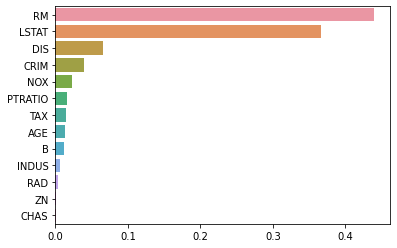

In [52]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators = 1000)

# 앞에서 만들어진 X_data, y_target 데이터셋을 적용해 학습  
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data = rf_reg.feature_importances_, index = X_data.columns )
feature_series = feature_series.sort_values(ascending = False) # 내림차순
sns.barplot(x = feature_series, y = feature_series.index)

- 회귀 트리 Regressor가 어떻게 예측값을 판단하는지 선형 회귀와 비교해 시각화해보기
- 회귀 예측선을 쉽게 표현하기 위해 단 1개의 변수만 추출하기
- price와 가장 밀접한 양의 상관관계를 가지는 RM 칼럼만 이용해 선형 회귀와 결정 트리 회귀로 PRICE 예측 회귀선을 표현해보기

(100, 2)


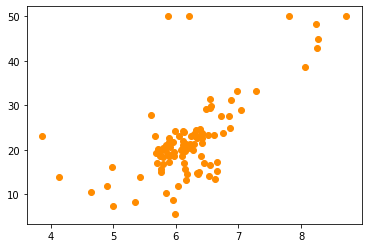

In [53]:
bostonDF_sample = bostonDF[['RM','PRICE']]
bostonDF_sample = bostonDF_sample.sample( n =100, random_state = 0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")

- LinearRegression과 DecisionTreeRegressor를 max_depth를 각각 2,7로 해서 학습해보기

In [55]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반 Regressor 생성하기
lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지 100개의 데이터 세트로 생성하기
X_test = np.arange(4.5,8.5,0.04).reshape(-1,1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 rm만, 결정 데이터인 price 추출하기
X_feature = bostonDF_sample['RM'].values.reshape(-1,1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1,1)

# 학습 및 예측 수행하기
lr_reg.fit(X_feature,y_target)
rf_reg2.fit(X_feature,y_target)
rf_reg7.fit(X_feature,y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

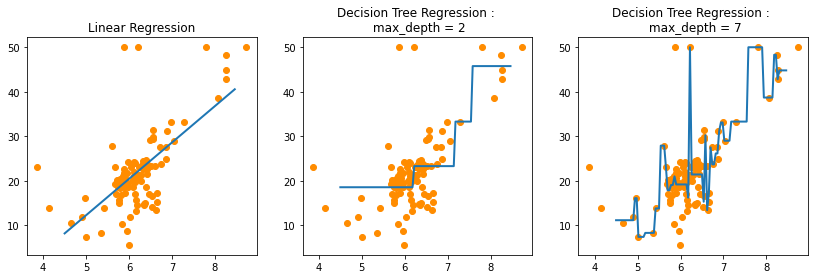

In [56]:
#  선형 회귀와 결정 트리 회귀 예측선 시각화
fig , (ax1, ax2, ax3) = plt.subplots(figsize = (14,4), ncols = 3)

# 선형 회귀로 학습된 모델 회귀 예측선 
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax1.plot(X_test, pred_lr,label = "linear", linewidth = 2 )

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선 
ax2.set_title('Decision Tree Regression : \n max_depth = 2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax2.plot(X_test, pred_rf2, label = "max_depth : 3", linewidth = 2 )

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선 
ax3.set_title('Decision Tree Regression : \n max_depth = 7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = "darkorange")
ax3.plot(X_test, pred_rf7, label = "max_depth : 7", linewidth = 2)

- 결과
      1. 선형 회귀는 직선으로 예측 회귀서을 표현하는데 반해, 회귀 트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선을 만듦
      2. DecisionTreeRegressor의 max_depth=7인 경우에는 학습 데이터 세트의 이상치 데이터도 학습하면서 복잡한 계단 형태의 회귀선을 만들어 과적합이 되기 쉬운 모델이 되었음을 알 수 있음